# Apprenticeship Learning via IRL - Deep Q Learning

## Cartpole-v0

[CartPole-v0 Wiki](https://github.com/openai/gym/wiki/CartPole-v0)

In [1]:
import os
import gym
import math
import copy
import torch
import tqdm
import random
import pathlib
import argparse
import matplotlib
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import namedtuple
import torchvision.transforms as T

In [2]:
# Class to store the experiences (transitions) of the agent as it interacts with the environment

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity   # maximum number of transitions the buffer can hold
        self.memory = []           # list to store the transitions
        self.position = 0          # counter to keep track of the next available slot in the buffer

    def push(self, *args):
        """
        Save a transition in the replay memory.

        Parameters:
        - *args: Tuple representing a transition.
        """
        
        if len(self.memory) < self.capacity:                  # if buffer not full, appends the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)        # overwrites the transition at the current position
        self.position = (self.position + 1) % self.capacity   # update counter to the next available slot

    def sample(self, batch_size):
        """
        Sample a batch of transitions from the replay memory.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """
        Return the current size of the replay memory.
        """
        return len(self.memory)

In [3]:
# transition in the replay memory

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
# Neural Network for Deep Q Learning 

HIDDEN_LAYER = 64

class DQN(nn.Module):
    def __init__(self):
        """
        Initialize the DQN model.

        The model consists of three hidden layers with ReLU activation functions.

        Input:
        - 4 input features (state space)
        - HIDDEN_LAYER number of neurons in each hidden layer
        
        Output:
          - 2 output neurons representing Q-values for each action
        """
        
        super().__init__()
        
        self.il = nn.Linear(4, HIDDEN_LAYER)
        self.h1 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.h2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        # self.h3 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.ol = nn.Linear(HIDDEN_LAYER, 2)

    def forward(self, x):
        """
        Define the forward pass of the model.

        Parameters:
        - x: Input state.

        Returns:
        - Output Q-values for each action.
        """
        x = F.relu(self.il(x))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        # x = F.relu(self.h3(x))
        x = self.ol(x)
        return x

In [5]:
# Class for training agent (expert)

class DQNTrainer:
        
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    BATCH_SIZE = 128
    GAMMA = 0.999
    EPS_START = 0.95
    num_episodes = 200
    EPS_END = 0.05
    EPS_DECAY = num_episodes * 0.9
    TARGET_UPDATE = 10
    resize = T.Compose([T.ToPILImage(),
                        T.Resize(40, interpolation=Image.BICUBIC),
                        T.ToTensor()])

    def __init__(self, args, env, name):
        
        save_path = f'../Results/DQN/{name}/'
        pathlib.Path(save_path).mkdir(parents=True, exist_ok=True)

        self.env = gym.wrappers.Monitor(env, save_path, video_callable=lambda episode_id: episode_id % 199 == 0, 
                                        force=True)
        # records a video for every 199th episode
        self.env.reset()

        self.policy_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.is_trained = False
        self.avg_feature = None

        if args.config_str is not None:     # load pretrained model if given
            self.is_trained = True
            pth = os.path.abspath(args.config_str)
            assert pathlib.Path(pth).exists()
            data = torch.load(pth)
            self.policy_net.load_state_dict(data['mdl'])
            self.avg_feature = data.get('avgFeat')
            print('LOADED MODEL')

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.best_model = None
        self.best_rwd = -float('inf')

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.memory = ReplayMemory(100000)

        self.NUM_UPDATE = 1
        self.steps_done = 0
        self.episode_durations = []
        self.plot = args.plot
        self.name = name
        plt.ion()

        if self.plot:
            plt.figure()
            self.init_screen = self.get_screen()
            plt.imshow(self.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
            plt.title('Example Extracted Screen')


    def get_cart_location(self, screen_width):

        world_width = self.env.unwrapped.x_threshold * 2
        scale = screen_width / world_width

        # horizontal position of the cart's center on the screen
        cart_position_on_screen = int(self.env.unwrapped.state[0] * scale + screen_width / 2.0)

        return cart_position_on_screen

    
    def get_screen(self):
        
        # Get the screen from the environment and transpose it into torch order (CHW)
        screen = self.env.render(mode='rgb_array').transpose((2, 0, 1))

        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        top_cutoff, bottom_cutoff = int(screen_height * 0.4), int(screen_height * 0.8)
        screen = screen[:, top_cutoff:bottom_cutoff]

        # position of the cart on the screen
        view_width = int(screen_width * 0.6)
        cart_location = self.get_cart_location(screen_width)

        # define the range for extracting a square image centered on the cart
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

        # Extract the square image centered on the cart
        screen = screen[:, :, slice_range]

        # Convert to float, rescale, convert to torch tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Resize, and add a batch dimension (NCHW)
        return self.resize(screen).unsqueeze(0).to(self.device)
    

    def select_action(self, state):
        
        sample = random.random()
        
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        
        self.steps_done += 1

        if sample > eps_threshold:
            # Exploitation: Choose the action with the larger expected reward
            with torch.inference_mode():
                return self.policy_net(state).max(1)[1].view(1, 1)   # second column on max result is index of where max element was
        else:
            # Exploration: Choose a random action
            return torch.tensor([[random.randrange(2)]], device=self.device, dtype=torch.long)

        
    def optimize_model(self):
        
        # Check if there are enough samples in the replay memory
        if len(self.memory) < self.BATCH_SIZE:
            return

        # Perform multiple updates to the model
        for i in range(self.NUM_UPDATE):
            
            # Sample a batch of transitions from the replay memory
            transitions = self.memory.sample(self.BATCH_SIZE)
            
            # Transpose the batch of transitions - converts batch-array of Transitions to Transition of batch-arrays.
            batch = Transition(*zip(*transitions))

            # Create a mask for non-final states and concatenate batch elements
            # (a final state would've been the one after which simulation ended)
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                   batch.next_state)), device=self.device, dtype=torch.uint8)
            
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            
            state_batch = torch.cat([s.to(self.device) for s in batch.state])
            action_batch = torch.cat([a.to(self.device) for a in batch.action])
            reward_batch = torch.cat([r.to(self.device) for r in batch.reward])


            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
            # columns of actions taken. These are the actions which would've been taken
            # for each batch state according to policy_net
            # Q values for the current state-action pairs using the current policy network
            state_action_values = self.policy_net(state_batch).gather(1, action_batch)

            # Compute V(s_{t+1}) for all next states.
            # Expected values of actions for non_final_next_states are computed based
            # on the "older" target_net; selecting their best reward with max(1)[0].
            # This is merged based on the mask, such that we'll have either the expected
            # state value or 0 in case the state was final.
            next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

            # Compute the expected Q values for the current state-action pairs using bellman equation
            expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

            # Compute Huber loss - smooth L1 loss function. 
            # It measures the difference between the predicted Q values and the expected Q values
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

            # Optimize the model
            # sets the gradients to zero, backpropagates the loss, applies gradient clipping 
            # and updates the model's parameters using the optimizer
            self.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

            
    def testModel(self, mdl, save_states=False):
        
        ep_rwd = 0  # Initialize total episode reward
        state_list = []  # List to store feature vectors if save_states is True

        # Reset the environment and obtain the initial state
        state_tp = self.env.reset()
        state = torch.from_numpy(state_tp).unsqueeze(0).to(self.device, dtype=torch.float)

        # Save the initial state's feature vector if save_states is True
        if save_states:
            state_list.append(self.featurefn(state_tp))

        with torch.no_grad():
            for t in count():
                # Select an action using the provided model
                a = mdl(state).max(1)[1].view(1, 1)

                # Take a step in the environment
                state_tp, reward, done, _ = self.env.step(a.item())

                # Update the current state
                state = torch.from_numpy(state_tp).unsqueeze(0).to(self.device, dtype=torch.float)

                # Save the feature vector of the current state if save_states is True
                if save_states:
                    state_list.append(self.featurefn(state_tp))

                # Update the total episode reward
                ep_rwd += reward

                # Break if the episode is done or exceeds a maximum time step
                if done or t > 30000:
                    break

        # Based on the total reward for the episode, determine the best model
        if ep_rwd > self.best_rwd and not save_states:
            self.best_rwd = ep_rwd
            self.best_model = copy.deepcopy(mdl)

        # Return the total episode reward and the list of feature vectors if save_states is True
        if not save_states:
            return ep_rwd
        else:
            return ep_rwd, state_list


    def featurefn(self, state):
        
        # Normalize state components
        x, x_dot, theta, theta_dot = state
        x = (x + self.env.unwrapped.x_threshold) / (2 * self.env.unwrapped.x_threshold)
        x_dot = (x_dot + self.env.unwrapped.x_threshold) / (2 * self.env.unwrapped.x_threshold)
        theta = (theta + self.env.unwrapped.theta_threshold_radians) / (2 * self.env.unwrapped.theta_threshold_radians)
        theta_dot = (theta_dot + self.env.unwrapped.theta_threshold_radians) / (2 * self.env.unwrapped.theta_threshold_radians)

        # Construct feature vector
        feat = torch.tensor([
            x, x_dot, theta, theta_dot,
            x ** 2, x_dot ** 2, theta ** 2, theta_dot ** 2,
        ])

        return feat

    def train(self, rwd_weight=None):
        
        for i_episode in range(self.num_episodes):
            
            # Initialize the environment and state
            state = torch.from_numpy(self.env.reset()).unsqueeze(0).to(self.device, dtype=torch.float)
            
            for t in count():
                # Select and perform an action
                action = self.select_action(state)
                next_state_np, reward, done, _ = self.env.step(action.item())

                # Optionally visualize the screen (if plotting is enabled)
                if self.plot and i_episode % 100 == 0:
                    self.get_screen()

                # Prepare next state
                next_state = torch.from_numpy(next_state_np).unsqueeze(0).to(self.device, dtype=torch.float)

                # Adjust the reward based on the reward weight or environment-specific criteria
                if rwd_weight is None:
                    reward = torch.tensor([reward], device=self.device)
                    x, x_dot, theta, theta_dot = next_state_np   # normalization
                    r1 = (self.env.unwrapped.x_threshold - abs(x)) / self.env.unwrapped.x_threshold - 0.8
                    r2 = (self.env.unwrapped.theta_threshold_radians - abs(theta)) / self.env.unwrapped.theta_threshold_radians - 0.5
                    reward = torch.tensor([r1 + r2])
                else:
                    feat = self.featurefn(next_state_np)
                    reward = rwd_weight.t() @ feat

                # Observe new state
                if done:
                    next_state = None

                # Store the transition in self.memory
                self.memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the target network)
                self.optimize_model()

                # Break if episode is done or exceeds a maximum number of steps
                if done or t > 30000:
                    self.episode_durations.append(t + 1)
                    self.showProgress(i_episode)
                    break

            # Do not test the model until at least 100 episodes have passed
            policy_rwd = 0
            if i_episode > 100:
                policy_rwd = self.testModel(self.policy_net)
                print('Policy Reward: ', policy_rwd)

            # Update the target network weights every TARGET_UPDATE episodes
            if i_episode % self.TARGET_UPDATE == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        # Done training
        print('Complete')
        self.is_trained = True
        pathlib.Path('../Results/DQN/Plots/').mkdir(parents=True, exist_ok=True)
        plt.savefig(f'../Results/DQN/Plots/Train-{self.name}.png')
        if self.plot:
            self.env.render()
            self.env.close()
            plt.ioff()
            plt.show()

    def showProgress(self, e_num):
        
        # Calculate the mean duration of the last 100 episodes
        means = 0
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)

        if len(self.episode_durations) >= 100:
            means = durations_t[-100:-1].mean().item()

        # Print information about the current episode
        info_str = f'Episode {e_num}/{self.num_episodes} -- Duration: {durations_t[-1]} -- AVG: {means}'
        print(info_str)

        # Plot the episode durations
        plt.figure(2)
        plt.clf()
        plt.title(f'Performance: {self.name}')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())

        # If plotting is enabled, also plot the rolling average of durations
        if self.plot:
            if len(durations_t) >= 100:
                means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
                means = torch.cat((torch.zeros(99), means))
                plt.plot(means.numpy())

            # Pause to allow plots to be updated
            plt.pause(0.001)


    def saveBestModel(self):
        
        # directory to save models
        pathlib.Path('../Data/Models/').mkdir(parents=True, exist_ok=True)

        # Create a dictionary containing the state_dict of the best model and the average feature
        state = {
            'mdl': self.best_model.state_dict(),
            'avgFeat': self.avgFeature
        }

        import datetime
        now = datetime.datetime.now()

        save_name = f'../Data/Models/model_DATE-{now.isoformat()}.pth.tar'
        print(save_name)

        # Save the state dictionary
        torch.save(state, save_name)

    def gatherAverageFeature(self):

        with torch.inference_mode():

            n_iter = 2000

            sample_sum = None
            rwd_sum = None

            # Iterate through episodes to collect features and rewards
            for i in tqdm.tqdm(range(n_iter)):
                
                # Call the testModel method to get rewards and states
                rwd, states = self.testModel(self.best_model, True)

                # Calculate the mean feature vector across the episode
                episode_mean = torch.stack(states).mean(0)

                # Accumulate feature and reward sums
                if sample_sum is None:
                    sample_sum = episode_mean
                    rwd_sum = rwd
                else:
                    sample_sum += episode_mean
                    rwd_sum += rwd

            # Calculate the average feature vector and reward over all iterations
            sample_sum /= n_iter
            rwd_sum /= n_iter

            # Print the calculated average feature and reward
            print('Average Feature: ',sample_sum)
            print('Average Reward: ',rwd_sum)

        # Update the class attribute 'avgFeature' with the calculated average feature
        self.avgFeature = sample_sum

        # Return the calculated average feature and reward
        return sample_sum, rwd_sum

Episode 0/200 -- Duration: 23.0 -- AVG: 0
Episode 1/200 -- Duration: 26.0 -- AVG: 0
Episode 2/200 -- Duration: 9.0 -- AVG: 0
Episode 3/200 -- Duration: 20.0 -- AVG: 0
Episode 4/200 -- Duration: 11.0 -- AVG: 0
Episode 5/200 -- Duration: 28.0 -- AVG: 0
Episode 6/200 -- Duration: 14.0 -- AVG: 0
Episode 7/200 -- Duration: 21.0 -- AVG: 0
Episode 8/200 -- Duration: 12.0 -- AVG: 0
Episode 9/200 -- Duration: 9.0 -- AVG: 0
Episode 10/200 -- Duration: 11.0 -- AVG: 0
Episode 11/200 -- Duration: 13.0 -- AVG: 0
Episode 12/200 -- Duration: 60.0 -- AVG: 0
Episode 13/200 -- Duration: 95.0 -- AVG: 0
Episode 14/200 -- Duration: 109.0 -- AVG: 0
Episode 15/200 -- Duration: 49.0 -- AVG: 0
Episode 16/200 -- Duration: 68.0 -- AVG: 0
Episode 17/200 -- Duration: 36.0 -- AVG: 0
Episode 18/200 -- Duration: 42.0 -- AVG: 0
Episode 19/200 -- Duration: 35.0 -- AVG: 0
Episode 20/200 -- Duration: 61.0 -- AVG: 0
Episode 21/200 -- Duration: 169.0 -- AVG: 0
Episode 22/200 -- Duration: 147.0 -- AVG: 0
Episode 23/200 -- Du

Episode 146/200 -- Duration: 200.0 -- AVG: 199.83837890625
Policy Reward:  200.0
Episode 147/200 -- Duration: 200.0 -- AVG: 199.83837890625
Policy Reward:  200.0
Episode 148/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 149/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 150/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 151/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 152/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 153/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 154/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 155/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 156/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 157/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 158/200 -- Duration: 200.0 -- AVG: 200.0
Policy Reward:  200.0
Episode 159/200 -- Duration: 200.0 -- AVG: 200.0
Policy R

100%|███████████████████████████████████████| 2000/2000 [01:11<00:00, 27.80it/s]

Average Feature:  tensor([0.4950, 0.4968, 0.4988, 0.4998, 0.2452, 0.2476, 0.2490, 0.4857],
       dtype=torch.float64)
Average Reward:  200.0


(tensor([0.4950, 0.4968, 0.4988, 0.4998, 0.2452, 0.2476, 0.2490, 0.4857],
        dtype=torch.float64),
 200.0)

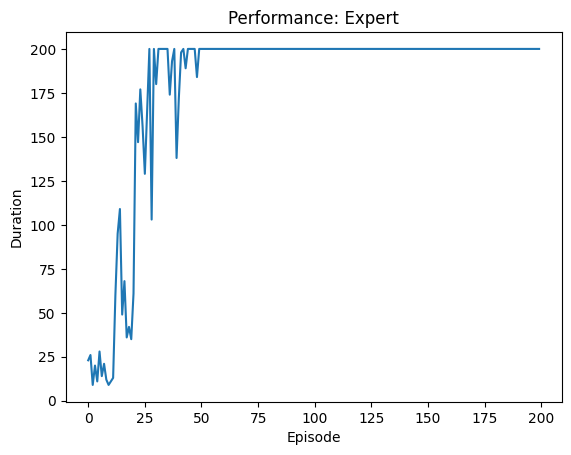

In [7]:
env = gym.make('CartPole-v0')

args = argparse.Namespace(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    BATCH_SIZE=128,
    GAMMA=0.999,
    EPS_START=0.95,
    num_episodes=200,
    EPS_END=0.05,
    EPS_DECAY=200*0.9,
    TARGET_UPDATE=10,
    config_str=None,
    plot=False
)

dqn_trainer = DQNTrainer(env=env, args=args, name='Expert')
dqn_trainer.train()
dqn_trainer.saveBestModel()
dqn_trainer.gatherAverageFeature()